# Hidden Markov Models (HMMs)

A popular choice of state space model (SSM) in time-series applications is the <b>hidden Markov model (HMM)</b>. In this notebook, we will provide an introduction on how to represent an HMM, how to perform posterior inference and find the most probable state path with this model, as well as how to estimate the HMM's parameters. 

Let's first import the necessary modules, where we will use [Dynamax](https://github.com/probml/dynamax) as in the [Kalman filter (KF) example](kalman_filter.ipynb#Posterior-Inference-in-SSMs):

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors
# Color for 0 and 1
state_cmap = matplotlib.colors.ListedColormap(['orange', 'blue'])

import numpy as np

# GPU suitable form of NumPy, also works on the CPU
from jax import numpy as jnp
from jax import random as jr

# JAX library for SSMs
from dynamax.hidden_markov_model import CategoricalHMM

jnp.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness"
key = jr.PRNGKey(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Markov Chains

Markov chains are sequential models that assume an observation $\mathbf{x}_t$ at the current timestep $t$ is a <b>sufficient statistic</b> to predict the future:

\begin{equation*}
p(\mathbf{x}_{t+\tau} \, | \, \mathbf{x}_t, \mathbf{x}_{1:t-1}) = p(\mathbf{x}_{t+\tau} \, | \, \mathbf{x}_t),
\end{equation*}

for $\tau \geq 0$. In other words, given the present $\mathbf{x}_t$, the future is independent of the past. This is known as the <b>Markov assumption</b>. As a result, the joint distribution of a finite length sequence, with duration $T$, can be expressed as:

\begin{equation*}
p(\mathbf{x}_{1:T}) = p(\mathbf{x}_1) p(\mathbf{x}_2 \, | \, \mathbf{x}_1) p(\mathbf{x}_3 \, | \, \mathbf{x}_2) \ldots = p(\mathbf{x}_1) \prod_{t=2}^T p(\mathbf{x}_t \, | \, \mathbf{x}_{t-1}).
\end{equation*}


## State-Space Models (SSMs)

SSMs are <b>partially observed Markov chains</b>, which tells us two things about the dynamical system we are modeling:
1. The state of this dynamical system is only "partially observable", meaning there is a hidden variable, $\mathbf{z}_t \in \mathbb{R}^{N_z}$, that is assumed to be responsible for generating observations, $\mathbf{x}_t \in \mathbb{R}^{N_x}$, about the system's behavior.
2. The latent state's dynamics, $\mathbf{z}_t \in \mathbb{R}^{N_z}$, adhere to the Markov assumption.

Please refer to the [KF notebook](kalman_filter.ipynb#Posterior-Inference-in-SSMs) for a brief on the general problem of posterior inference in SSMs. As described in the KF notebook, we often assume that the observations are conditionally independent of one another, given $\mathbf{z}_t$, as opposed to being Markovian in their dependencies. An SSM can thus be described by the following joint distribution:

\begin{equation*}
p(\mathbf{x}_{1:T}, \mathbf{z}_{1:T}) = \left[ p(\mathbf{z}_1) \prod_{t=2}^T p(\mathbf{z}_t \, | \, \mathbf{z}_{t-1}) \right] \left[ \prod_{t=1}^T p(\mathbf{x}_t \, | \, \mathbf{z}_{t}) \right],
\end{equation*}

where $p(\mathbf{z}_1)$ is the prior distribution, $p(\mathbf{z}_t \, | \, \mathbf{z}_{t-1})$ is the transition model, and $p(\mathbf{x}_t \, | \, \mathbf{z}_{t})$ is the observation model.

## HMM Representation

HMMs are SSMs with <b>discrete</b> hidden variables, $z_t \in \{1, \ldots, K\}$. This is in contrast to linear Gaussian SSMs or linear dynamical systems, which have continuous latent variables and can use the KF algorithm to recursively estimate the <i>belief state</i>, $p(\mathbf{z}_t \, | \, \mathbf{x}_{1:t})$. Note that the observations can be discrete, $x_t \in \{1, \ldots, N_x\}$, continuous, $\mathbf{x}_t \in \mathbb{R}^{N_x}$, or a mix of both.

Let us now walk through specifying each of the distributions for this generative model.

### State Transition Model

First, the <b>initial state distribution</b> can be written as:

\begin{equation*}
p(z_1 = j) = \pi_j,
\end{equation*}

for an arbitrary state $j$. We denote $\boldsymbol{\pi}$ as a categorical distribution over the $K$ states of the HMM.

The <b>transition model</b> can then be denoted as:

\begin{equation*}
p(z_t = j | z_{t-1} = i) = A_{ij},
\end{equation*}

where $\mathbf{A}$ is the $K \times K$ transition matrix (a row stochastic matrix, i.e., each row sums to one).

### Observation Model

On the other hand, the <b>observation likelihood</b>, $p(\mathbf{x}_t \, | \, z_{t} = j)$, is represented differently depending on the type of observation data, $\mathbf{x}_t$. For discrete observations or <i>emissions</i>, $x_t \in \{1, \ldots, N_x\}$, we could utilize:

\begin{equation*}
p(x_t = k \, | \, z_t = j) = B_{jk},
\end{equation*}

with $\mathbf{B}$ as the $K \times N_x$ observation matrix containing the emission probabilities. A similar form could be written for Bernoulli observations. For $D$ discrete observations per time step, or $D$ <i>number of emissions</i>, a factorial model could be adopted:

\begin{equation*}
p(\mathbf{x}_t \, | \, z_t = j) = \prod_{d=1}^D \text{Cat}(x_{td} \, | \, \mathbf{B}_{d,j,:}),
\end{equation*}

where $x_{td}$ is the $d^{th}$ observation at time $t$, and $\mathbf{B}_{d,j,:}$ is the $j^{th}$ row of the emission probabilities matrix for observation $d$.

Likewise, if $\mathbf{x}_t \in \mathbb{R}^{N_x}$ is continuous, then a common choice of likelihood model is the multivariate Gaussian distribution:

\begin{equation*}
p(\mathbf{x}_t \, | \, z_t = j) = \mathcal{N}(\mathbf{x}_t \, | \, \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j),
\end{equation*}

where $\boldsymbol{\mu}_j \in \mathbb{R}^{N_x}$ and $\boldsymbol{\Sigma}_j \in \mathbb{R}^{N_x \times N_x}$ are the mean and covariance matrix associated with the Gaussian distribution for hidden state $j$.

### Joint Distribution

To specify the joint distribution of an HMM, let us consider a <b>categorical HMM</b> with emissions $x_t$ that follow a categorical distribution and parameters $\boldsymbol{\theta} = (\boldsymbol{\pi}, \mathbf{A}, \mathbf{B})$ as the initial distribution, $\boldsymbol{\pi}$, the transition matrix, $\mathbf{A}$, and the emission probabilities, $\mathbf{B}$. The joint probability for a single sequence is thus:

\begin{align*}
p(\mathbf{x}_{1:T}, \mathbf{z}_{1:T} \, | \, \boldsymbol{\theta}) & = \left[ p(z_1 \, | \, \boldsymbol{\pi}) \right] \left[ \prod_{t=2}^T p(z_t \, | \, z_{t-1}, \mathbf{A}) \right] \left[ \prod_{t=1}^T p(x_t \, | \, z_{t},\mathbf{B}) \right] \\
& = \left[ \prod_{k=1}^K \pi_k^{\mathbb{I}(z_1 = k)} \right] \left[ \prod_{t=2}^T \prod_{j=1}^K \prod_{k=1}^K A_{jk}^{\mathbb{I}(z_{t-1}=j,z_t = k)} \right] \left[ \prod_{t=1}^T \prod_{k=1}^K \text{Cat}(x_t \, | \, \mathbf{B}_k)^{\mathbb{I}(z_t = k)} \right],
\end{align*}

where the indicator functions extract specific elements of the different parameter structures, e.g., $\mathbb{I}(z_t = k)$ in the observation model refers to the $k^{th}$ row of matrix $\mathbf{B}$. 

## Weather Prediction Example

There are three fundamental problems in HMMs [(Rabiner, 1989)](https://ieeexplore.ieee.org/abstract/document/18626):
1. The <b>Evaluation/Scoring/Likelihood</b> problem: Given an HMM specified by known parameters, $\boldsymbol{\theta}$, and a sequence of observations, $\mathbf{x}_{1:T}$, what is the likelihood of this observation sequence, $p(\mathbf{x}_{1:T} \, | \, \boldsymbol{\theta})$?
2. The <b>Decoding</b> problem: Given an HMM specified by known parameters, $\boldsymbol{\theta}$, and a sequence of observations, $\mathbf{x}_{1:T}$, what is the most likely state sequence, $\mathbf{z}_{1:T}^*$, to produce these observations?
3. The <b>Learning</b> problem: Given an HMM and a sequence of observations or a set of $N$ observation sequences, $\{\mathbf{x}_{n,1:T}\}_{n=1}^N$, how do we find the parameters, $\boldsymbol{\theta}$, to maximize the likelihood $\prod_n p(\mathbf{x}_{n, 1:T} \, | \, \boldsymbol{\theta})$?

Let's now ground these problems in the following weather prediction application. Suppose we have a friend, Maria, who performs daily activities based on the weather conditions. Assume we have no perfect information on the weather, but we are informed regularly on Maria's major day-to-day activities. Let us also assume that the weather can be modeled as a <b>discrete Markov chain</b>. On any given day, $t$, Maria performs one of three major activities: $x_t \in \{\text{clean}, \text{swim}, \text{shop}\}$, which we can observe. The weather on this same day is instead <i>hidden</i> from us, but can be described by two states: $z_t \in \{\text{rain}, \text{sun}\}$. Another similar weather prediction example could be on the basis of [whether Maria is holding an umbrella or not](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm#Example).

Under these conditions, we will consider the following HMM representation, with shaded nodes indicating observable variables:

<p align="center">
  <img src="../../docs/figures/hmm_weather.png?raw=true" width="478" height="340">
</p>

<br>

Using [JAX](https://github.com/google/jax) as our numerical computation library of choice, we can specify the parameters of our HMM, $\boldsymbol{\theta} = (\boldsymbol{\pi}, \mathbf{A}, \mathbf{B})$:

In [2]:
initial_probs = jnp.array([0.5, 0.5])
transition_matrix = jnp.array([[0.7, 0.4], 
                               [0.3, 0.6]])
emission_probs = jnp.array([[0.1, 0.6, 0.3],    # sun
                            [0.5, 0.1, 0.4]])   # rain

state_id_name_dict = {0: "sun", 1: "rain"}
observation_id_name_dict = {0: "clean", 1: "swim", 2: "shop"}

print(f"π shape: {initial_probs.shape}")
print(f"A shape: {transition_matrix.shape}")
print(f"B shape: {emission_probs.shape}")

π shape: (2,)
A shape: (2, 2)
B shape: (2, 3)


We can now also instantiate our `CategoricalHMM` class using the Dynamax library to implement our HMM given the above $\boldsymbol{\theta}$: 

In [3]:
num_states = 2      # two weather conditions
num_emissions = 1   # only one activity is observed per timestep/day
num_classes = 3     # each day can have one of three activities performed

# Construct the HMM
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

# Initialize the parameters struct with known values
params, _ = hmm.initialize(initial_probs=initial_probs,
                           transition_matrix=transition_matrix,
                           # Reshaped to accommodate a factorial model with D number of emissions
                           emission_probs=emission_probs.reshape(num_states, num_emissions, num_classes))
print(params)

ParamsCategoricalHMM(initial=ParamsStandardHMMInitialState(probs=Array([0.5, 0.5], dtype=float32)), transitions=ParamsStandardHMMTransitions(transition_matrix=Array([[0.7, 0.4],
       [0.3, 0.6]], dtype=float32)), emissions=ParamsCategoricalHMMEmissions(probs=Array([[[0.1, 0.6, 0.3]],

       [[0.5, 0.1, 0.4]]], dtype=float32)))


Note that Maria performs only a single major activity per day, $t$, so there is no need to consider $D$ discrete observations per time step, i.e., `num_emissions`. The `CategoricalHMM` does however accommodate this type of factorial model if desired.

### Sampling Data

Let us now sample data from this HMM, assuming a full year of Maria's daily activities observed $T=365$.

States shape: (365,)
Emissions shape: (365, 1)

First week's states:     rain rain sun rain rain rain sun
First week's emissions:  swim shop shop shop clean clean swim


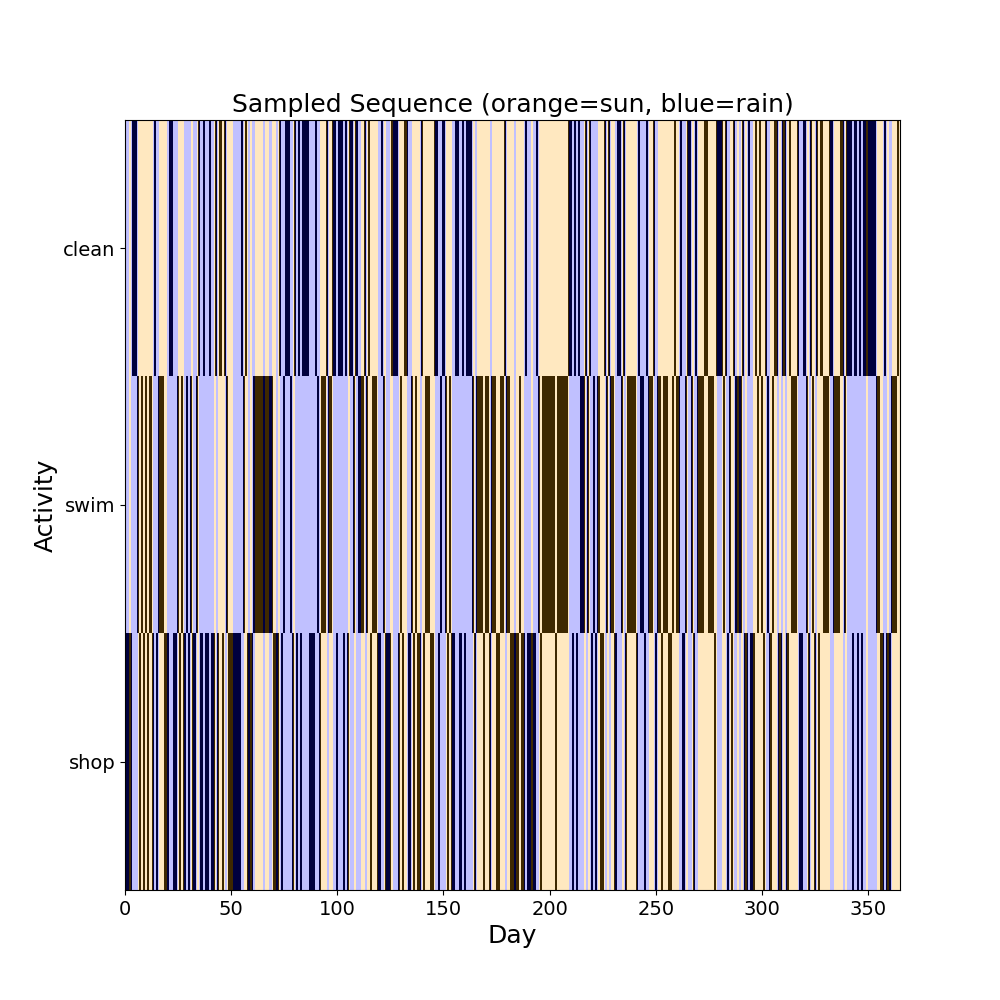

In [4]:
T = 365
z, x = hmm.sample(params, key, T)

print(f"States shape: {z.shape}")
# The last dimension of 1 here relates to the num_emissions parameter
print(f"Emissions shape: {x.shape}")
print("")
print("First week's states:    ", *map(state_id_name_dict.get, np.array(z[:7])))
print("First week's emissions: ", *map(observation_id_name_dict.get,  np.array(x[:7, 0])))

def plot_sequence(states, emissions):
    # Convert to one-hot to plot as an image (N_x, T)
    one_hot_emissions = np.squeeze(np.eye(num_classes)[emissions.reshape(-1)])

    fig = plt.figure(figsize=(10, 10))
    # Activities are color-coded gray when observed on a given day 
    # Transpose to have x-axis for days and y-axis for emission index
    plt.imshow(one_hot_emissions.T, aspect='auto', interpolation='none', cmap='Greys')
    
    # For the states image, we need an extra dimension to treat the 1D sequence as a 2D matrix
    # extent controls the space in the image that is filled 
    plt.imshow(states[None, :], extent=(0, T, num_classes-.5, -.5), 
               interpolation='none', aspect='auto', cmap=state_cmap, alpha=0.25)
    
    plt.xlabel("Day")
    plt.ylabel("Activity")
    plt.yticks(jnp.arange(num_classes), [observation_id_name_dict[i] for i in (np.arange(num_classes))])
    plt.title("Sampled Sequence (orange=sun, blue=rain)")
    plt.show()
    
plot_sequence(z, x)

### The Evaluation Problem: Forwards-Backwards Algorithm

The first problem is to compute the likelihood of an observation sequence, $p(\mathbf{x}_{1:T} \, | \, \boldsymbol{\theta})$, given known parameters of the HMM, $\boldsymbol{\theta}$ (dropped for brevity in the following, as assumed known). Estimating this marginal likelihood can be useful when comparing and fitting models.

Suppose Maria has the 3-day activity sequence: <i>swim shop shop</i>. We want to find the probability of this sequence occurring, but we have no knowledge about a critical dependency: the weather, i.e., $z_t$. 

For a Markov chain, where there are no hidden states, the likelihood could be calculated by simply tracing the emission events and multiplying probabilities along the arcs of the graph:

\begin{equation*}
p(\mathbf{x}_{1:T}) = p(x_1) p(x_2 \, | \, x_1) p(x_3 \, | \, x_2) \ldots p(x_T \, | \, x_{T-1}).
\end{equation*}

Let us apply a similar simplification in our HMM application to weather prediction by pretending the hidden states are known, e.g., <i>sun sun rain</i>. The likelihood of the observation sequence would then be:

\begin{equation*}
p(\mathbf{x}_{1:T} \, | \, \mathbf{z}_{1:T})  = \prod_{t=1}^T p(x_t \, | \, z_{t}),
\end{equation*}

which for our example sequence would be:

\begin{equation*}
p(\text{swim} \ \text{shop} \ \text{shop} \, | \, \text{sun} \ \text{sun} \ \text{rain})  = p(\text{swim} \, | \, \text{sun}) \times p(\text{shop} \, | \, \text{sun}) \times p(\text{shop} \, | \, \text{rain}).
\end{equation*}

However, we do not know the hidden states! A naïve approach to the problem of "scoring" an observation sequence would be to marginalize over all possible state sequences in our joint probability, $p(\mathbf{x}_{1:T}, \mathbf{z}_{1:T})$:

\begin{equation*}
p(\mathbf{x}_{1:T})  = \sum_{z_1} \cdots \sum_{z_{T}} p(\mathbf{x}_{1:T}, \mathbf{z}_{1:T}) = \sum_{z_1} \cdots \sum_{z_{T}} p(\mathbf{x}_{1:T} \, | \, \mathbf{z}_{1:T}) p(\mathbf{z}_{1:T}).
\end{equation*}

For the sequence <i>swim shop shop</i>, computing the marginal likelihood equates to summing over all possible weather conditions, weighted by their prior probability, i.e., $2^3$ possibilities:

\begin{equation*}
p(\text{swim} \ \text{shop} \ \text{shop})  = p(\text{swim} \ \text{shop} \ \text{shop}, \text{sun} \ \text{sun} \ \text{sun}) + p(\text{swim} \ \text{shop} \ \text{shop}, \text{sun} \ \text{sun} \ \text{rain})  + p(\text{swim} \ \text{shop} \ \text{shop}, \text{rain} \ \text{rain} \ \text{sun}) + \ldots
\end{equation*}

More generally, an HMM with $K$ hidden states and an observation sequence of length $T$, requires the evaluation of $K^T$ state sequences. This is prohibitively large for most real-world tasks with moderately long sequences. 

Instead, we opt to use a [dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming) approach that takes $O(K^2T)$ time. In essence, the idea is to exploit the conditional independence properties of the HMM and <i>recursively</i> calculate the <b>filtering distribution</b>:

\begin{equation*}
p(z_t \, | \, \mathbf{x}_{1:t})  \propto \sum_{z_1} \cdots \sum_{z_{t-1}} p(\mathbf{z}_{1:t}, \mathbf{x}_{1:t}),
\end{equation*}

from which we can obtain an estimate of the marginal likelihood $p(\mathbf{x}_{1:T})$.

#### The Forwards Algorithm (Filtering)

In our KF notebook, [Bayes filtering](kalman_filter.ipynb#Bayesian-Filtering) was presented as a means of recursively estimating the belief state $p(z_t \, | \, \mathbf{x}_{1:t})$ given the prior estimate $p(z_{t-1} \, | \, \mathbf{x}_{1:t-1})$. For HMMs, computing these probabilities across all timesteps in a recursive manner is referred to as the <b>forwards algorithm</b>. We can thus define the <b>forward variable</b> as a vector $\alpha_t(j) \triangleq p(z_t = j \, | \, \mathbf{x}_{1:t})$ for an arbitrary hidden state $j$. 

As with the Bayes filter, we can derive the forward variable by first performing a prediction step:

\begin{equation*}
\alpha_{t|t-1}(j) = p(z_t = j \, | \, \mathbf{x}_{1:t-1}) = \sum_i p(z_t = j \, | \, z_{t-1} = i)p(z_{t-1} = i \, | \, \mathbf{x}_{1:t-1}) = \sum_i A_{ij} \alpha_{t-1}(i),
\end{equation*}

where $A_{ij}$ is the transition probability from state $i$ to $j$ and $\alpha_{t-1}(i)$ is the previous forward path probability. We then perform an update step (Bayes rule):

\begin{equation*}
\alpha_{t}(j) =  \frac{1}{Z_t} p(x_t \, | \, z_{t} = j)p(z_{t} = j \, | \, \mathbf{x}_{1:t-1}) = \frac{1}{Z_t} p(x_t \, | \, z_{t} = j) \alpha_{t|t-1}(j) = \frac{1}{Z_t} p(x_t \, | \, z_{t} = j) \sum_i A_{ij} \alpha_{t-1}(i),
\end{equation*}

for normalization constant $Z_t \triangleq p(x_t \, | \, \mathbf{x}_{1:t-1})$. Here, the recursive calculation of $\alpha_t$ from $\alpha_{t-1}$ means we have circumvented exponential time complexity. Lastly, a marginal likelihood estimate, $p(\mathbf{x}_{1:T})$, is returned at the terminating condition, $T$, of the observation sequence:

\begin{equation*}
p(\mathbf{x}_{1:T}) = \sum_j \alpha_T(j) = \frac{1}{Z_T}  \sum_j \left[ p(x_T \, | \, z_{T} = j) \sum_i A_{ij} \alpha_{T-1}(i) \right].
\end{equation*}

The forwards algorithm is implemented using Dynamax as follows:

Marginal likelihood: -398.43
Filtered probabilities shape: (365, 2)


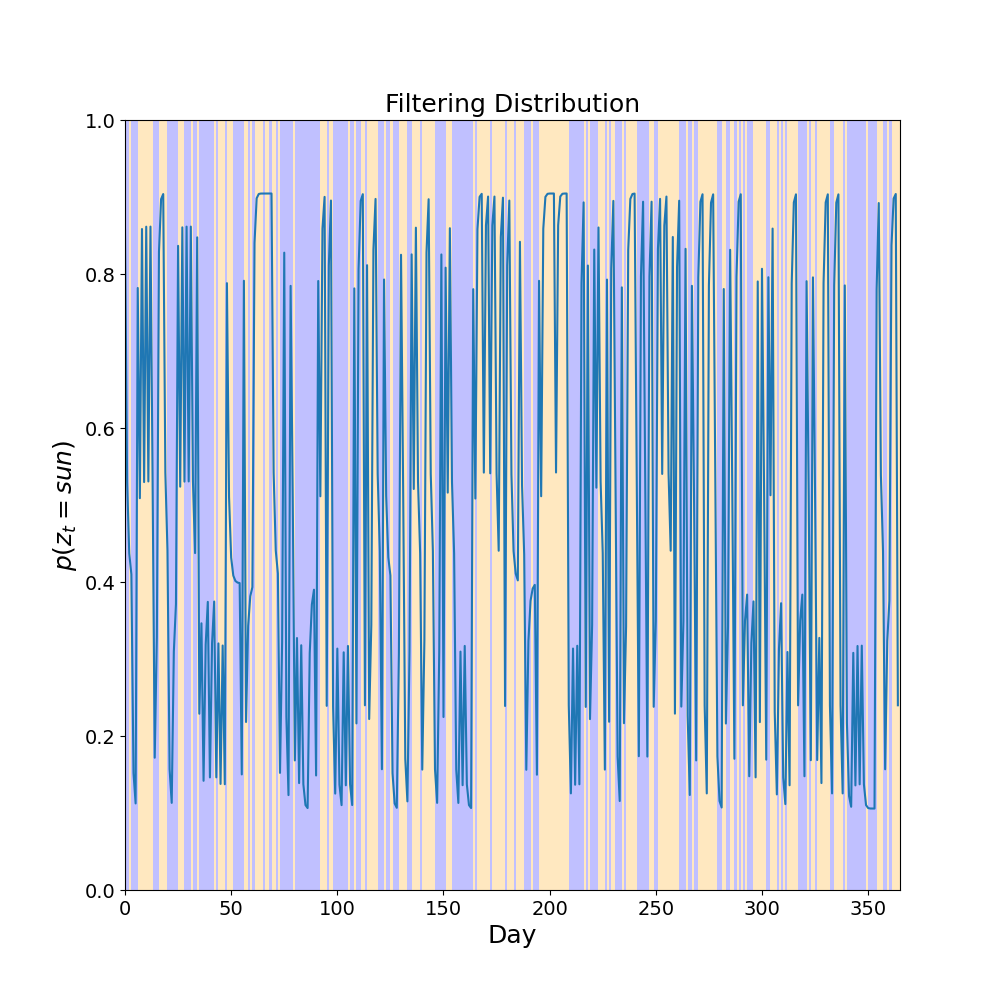

In [8]:
z_given_x = hmm.filter(params, x)
print(f"Marginal likelihood: {z_given_x.marginal_loglik: .2f}")
print(f"Filtered probabilities shape: {z_given_x.filtered_probs.shape}")

def plot_posterior_probs(probs, states, title=""):
    fig = plt.figure(figsize=(10, 10))
    
    plt.imshow(states[None, :], extent=(0, T, 0, 1), 
               interpolation='none', aspect='auto', cmap=state_cmap, alpha=0.25)
    plt.plot(probs[:, 0])   # probability of the weather being sunny (z=0)
    plt.xlabel("Day")
    plt.ylabel(r"$p(z_t = sun)$")
    plt.ylim(0, 1)
    plt.title("Filtering Distribution")
    
    plt.show()
    
plot_posterior_probs(z_given_x.filtered_probs, z)

### The Decoding Problem: Viterbi Algorithm

### The Learning Problem: Baum-Welch Algorithm

## References

Code adapted from <i>"casino_hmm_inference.ipynb"</i> and <i>"casino_hmm_learning.ipynb"</i> at:

@book{pml2Book,<br>
&emsp; author = "Kevin P. Murphy",<br>
&emsp; title = "Probabilistic Machine Learning: Advanced Topics",<br>
&emsp; publisher = "MIT Press",<br>
&emsp; year = 2023,<br>
&emsp; url = "http://probml.github.io/book2"<br>
}